In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import os

In [2]:
print(plt.rcParams["figure.figsize"])
backupPlotSize = [6.0, 4.0]

[6.0, 4.0]


# 1. Feature points detectors

## 1.a) Hessian matrix H(x,y)

In [3]:
def getGaussianKernel(stDev):
    kerSize = int(2*3*stDev + 1)
    x=np.arange(-(kerSize // 2),(kerSize // 2)+1 )
    gaus = np.exp(-(x**2)/(2*stDev**2))/ (np.sqrt(2*np.pi)*stDev)
    #gaus=(1/np.sqrt(2*np.pi*stDev)) * np.exp(-(x*x/(2*stDev*stDev)))
    gaus = gaus/sum(gaus)
    return np.array([gaus])


def getGaussianDx(stDev):
    kerSize = int(6*stDev + 1)
    x=np.arange(-(kerSize // 2),(kerSize // 2)+1 )
    gaus = -x*np.exp(-(x*x)/(2*stDev*stDev))/ (np.sqrt(2*np.pi)*stDev*stDev*stDev)
    gaus = gaus/sum(np.abs(gaus))
    return np.array([gaus])

#dva filtra da, ful packasto uglavnem
def applyFilter2(image, kernel1, kernel2):
    kernel1 = np.flip(kernel1)
    kernel2 = np.flip(kernel2)

    imageFiltered = cv2.filter2D(image, ddepth=-1, kernel=kernel1)
    imageFiltered = cv2.filter2D(imageFiltered, ddepth=-1, kernel=kernel2)

    return imageFiltered

def applyFilter(image, kernel):
    #dvakrat gremo skoz, enkrat transponiramo namest n^2 -> 2n
    imageFiltered = cv2.filter2D(image, ddepth=-1, kernel=kernel)
    imageFiltered = cv2.filter2D(imageFiltered, ddepth=-1, kernel=kernel.T)

    return imageFiltered

In [4]:
def getDerivative(img, sigma):
    g = getGaussianKernel(sigma)
    d = getGaussianDx(sigma)

    # np.flip(g)
    # np.flip(d)

    Ix = cv2.filter2D(img, cv2.CV_32F, g.T)
    Ix = cv2.filter2D(Ix, cv2.CV_32F, d)

    Iy = cv2.filter2D(img, cv2.CV_32F, g)
    Iy = cv2.filter2D(Iy, cv2.CV_32F, d.T)

    return Ix, Iy

def getSecondDerivative(img, sigma):
    g = getGaussianKernel(sigma)
    d = getGaussianDx(sigma)

    # np.flip(g)
    # np.flip(d)

    Ix = cv2.filter2D(img, cv2.CV_32F, g.T)
    Ix = cv2.filter2D(Ix, cv2.CV_32F, d)

    Iy = cv2.filter2D(img, cv2.CV_32F, g)
    Iy = cv2.filter2D(Iy, cv2.CV_32F, d.T)

    Ixx = cv2.filter2D(Ix, cv2.CV_32F, g.T)
    Ixx = cv2.filter2D(Ixx, cv2.CV_32F, d)

    Ixy=cv2.filter2D(Ix,  cv2.CV_32F, g)
    Ixy = cv2.filter2D(Ixy, cv2.CV_32F, d.T)

    Iyy = cv2.filter2D(Iy, cv2.CV_32F, g)
    Iyy = cv2.filter2D(Iyy, cv2.CV_32F, d.T)

    return Ixx, Ixy, Iyy

In [5]:
test = np.arange(12).reshape(3,4)
print(test)

test[test < 5] = 0
print(test)

ytest, xtest = np.nonzero(test)

print(ytest, xtest)

print(sum(sum(test)))

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]]
[[ 0  0  0  0]
 [ 0  5  6  7]
 [ 8  9 10 11]]
[1 1 1 2 2 2 2] [1 2 3 0 1 2 3]
56


In [6]:

# g = gauss(w)
# d = gaussdx(w)

# Ix = cv2.filter2D(I, cv2.CV_32F, g.T)
# Ix = cv2.filter2D(Ix, cv2.CV_32F, d)

# Iy = cv2.filter2D(I, cv2.CV_32F, g)
# Iy = cv2.filter2D(Iy, cv2.CV_32F, d.T)

# Ixx = cv2.filter2D(Ix, cv2.CV_32F, g.T)
# Ixx = cv2.filter2D(Ixx, cv2.CV_32F, d)

# Iyy = cv2.filter2D(Iy, cv2.CV_32F, g)
# Iyy = cv2.filter2D(Iyy, cv2.CV_32F, d.T)

In [7]:
def nonMaximaSupression2(image, thresh):
    image = np.copy(image)
    height, width = image.shape
    #da ne bo packarij
    image = np.pad(image,2)

    image[image <= thresh] = 0

    #array of nonzero x,y indexes, ubistvu x,y ampak sej ni vazn kr sm tud pol zamenu pri indeksiranju
    xa,ya = np.nonzero(image)

    mask = np.ones((5,5))
    mask[2,2]= 0

    #supress around neighborhood
    for i in range(len(xa)):
        x=xa[i]
        y=ya[i]
        if image[x,y] <= np.max(image[x-2:x+3, y-2:y+3]*mask):
            image[x,y] = 0
    

    return image[1:height+1, 1: width+1]

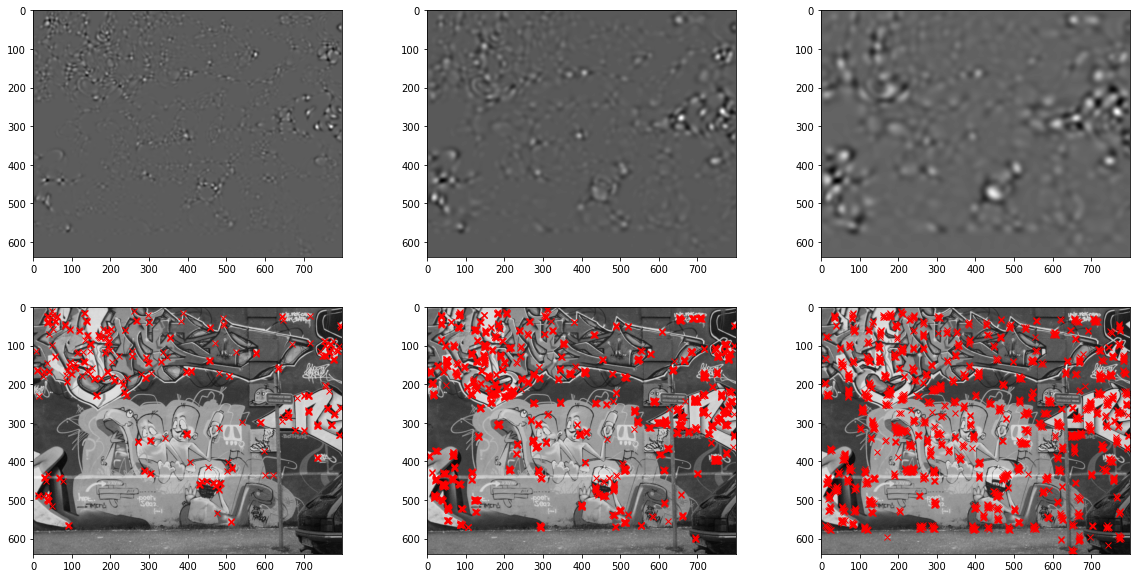

In [8]:
def hessianPoints(img, sigma, thresh):
    img=np.copy(img)
    img = cv2.GaussianBlur(img,(5,5),cv2.BORDER_DEFAULT)
    # gausKer = getGaussianKernel(sigma)
    # gausKerDx = getGaussianDx(sigma)

    # Ix = applyFilter2(img, gausKer.T, gausKerDx)
    # Ixx = applyFilter2(Ix, gausKer.T, gausKerDx)
    # Ixy = applyFilter2(Ix, gausKer, gausKerDx.T)
    # Iy = applyFilter2(img, gausKer, gausKerDx.T)
    # Iyy = applyFilter2(Iy, gausKer, gausKerDx.T)
    
    Ixx, Ixy, Iyy = getSecondDerivative(img, sigma)
    det = sigma**4 * (Ixx*Iyy - Ixy**2)

    return det

def nonMaximaSupression(image, thresh):
    image = np.copy(image)
    height, width = image.shape
    #da ne bo packarij
    image = np.pad(image,1)

    image[image <= thresh] = 0

    #array of nonzero x,y indexes, ubistvu x,y ampak sej ni vazn kr sm tud pol zamenu pri indeksiranju
    xa,ya = np.nonzero(image)

    mask = np.ones((3,3))
    mask[1,1]= 0

    #supress around neighborhood
    for i in range(len(xa)):
        x=xa[i]
        y=ya[i]
        if not image[x,y] > np.max(image[x-1:x+2, y-1:y+2]*mask):
            image[x,y] = 0
    

    return image[1:height+1, 1: width+1]


thresh = 20000
image = cv2.imread("graf1.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)



plt.rcParams["figure.figsize"] = [20,10]

plt.subplot(231)
hes1 = hessianPoints(image, 3, thresh)
plt.imshow(hes1, cmap="gray")

plt.subplot(232)
hes2 = hessianPoints(image, 6, thresh)
plt.imshow(hes2, cmap="gray")

plt.subplot(233)
hes3 = hessianPoints(image, 9, thresh)
plt.imshow(hes3, cmap="gray")

plt.subplot(234)
sup1 = nonMaximaSupression(hes1, thresh)
y,x = np.nonzero(sup1)
plt.imshow(image, cmap="gray")
plt.plot(x,y, marker='x', color="red", linestyle="None")


plt.subplot(235)
sup2 = nonMaximaSupression(hes2, thresh*6)
y,x = np.nonzero(sup2)
plt.imshow(image, cmap="gray")
plt.plot(x,y, marker='x', color="red", linestyle="None")

plt.subplot(236)
sup3 = nonMaximaSupression2(hes3, thresh*9)
y,x = np.nonzero(sup3)
plt.imshow(image, cmap="gray")
plt.plot(x,y, marker='x', color="red", linestyle="None")

plt.rcParams["figure.figsize"]=backupPlotSize


## 1.b) Harris detector

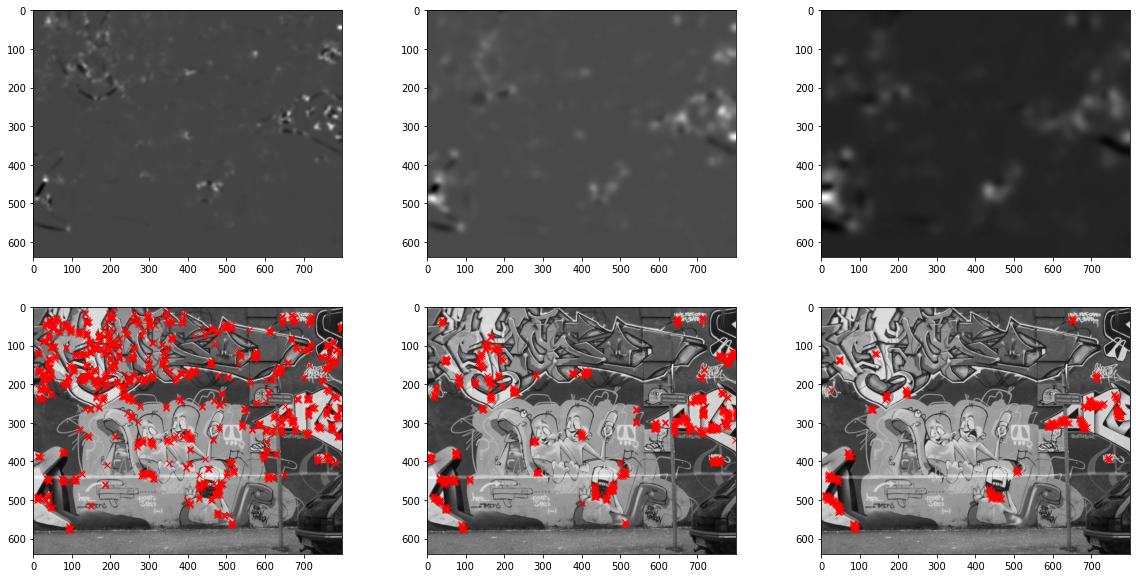

In [9]:
def harrisPoints(img, sigma, thresh):
    # img=np.copy(img)
    # img = cv2.GaussianBlur(img,(5,5),cv2.BORDER_DEFAULT)
    sigmaAp = 1.6*sigma
    alpha = 0.06

    Ix, Iy = getDerivative(img, sigma)
    gausKer = getGaussianKernel(sigmaAp)

    #create autocorrelation matrix M=[M11 M12; M21 M22]
    # M12 == M21
    
    M11=applyFilter(Ix*Ix,gausKer)
    #cv2.filter2D(Ix**2, cv2.CV_32F, gausKer)
    M22=applyFilter(Iy*Iy,gausKer)
    #M22=cv2.filter2D(Iy**2, cv2.CV_32F, gausKer)
    M12=applyFilter(Ix*Iy,gausKer)
    #M21=M12

    detM = M11*M22 - M12*M12
    traceM= M11 + M22

    harris = detM - alpha*traceM**2

    return harris

image = cv2.imread("graf1.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


thresh = 40000

plt.rcParams["figure.figsize"] = [20,10]

plt.subplot(231)
har1 = harrisPoints(image, 3, thresh)
plt.imshow(har1, cmap="gray")

plt.subplot(232)
har2 = harrisPoints(image, 6, thresh)
plt.imshow(har2, cmap="gray")

plt.subplot(233)
har3 = harrisPoints(image, 9, thresh)
plt.imshow(har3, cmap="gray")

plt.subplot(234)
sup1 = nonMaximaSupression2(har1, thresh)
y,x = np.nonzero(sup1)
plt.imshow(image, cmap="gray")
plt.plot(x,y, marker='x', color="red", linestyle="None")


plt.subplot(235)
sup2 = nonMaximaSupression2(har2, thresh*2)
y,x = np.nonzero(sup2)
plt.imshow(image, cmap="gray")
plt.plot(x,y, marker='x', color="red", linestyle="None")

plt.subplot(236)
sup3 = nonMaximaSupression2(har3, thresh*3)
y,x = np.nonzero(sup3)
plt.imshow(image, cmap="gray")
plt.plot(x,y, marker='x', color="red", linestyle="None")

plt.rcParams["figure.figsize"]=backupPlotSize

    

# 2. 

## 2.a) Findinng correspondances

In [10]:
def simple_descriptors(I, xpts, ypts, bins=16, radius=40, w=11):

    #sigmma=2

	g = getGaussianKernel(2)
	d = getGaussianDx(2)

	Ix = cv2.filter2D(I, cv2.CV_32F, g.T)
	Ix = cv2.filter2D(Ix, cv2.CV_32F, d)

	Iy = cv2.filter2D(I, cv2.CV_32F, g)
	Iy = cv2.filter2D(Iy, cv2.CV_32F, d.T)

	Ixx = cv2.filter2D(Ix, cv2.CV_32F, g.T)
	Ixx = cv2.filter2D(Ixx, cv2.CV_32F, d)

	Iyy = cv2.filter2D(Iy, cv2.CV_32F, g)
	Iyy = cv2.filter2D(Iyy, cv2.CV_32F, d.T)

	mag = np.sqrt(Ix**2+Iy**2)
	mag = np.floor(mag*((bins-1)/np.max(mag)))

	feat = Ixx+Iyy
	feat+=abs(np.min(feat))
	feat = np.floor(feat*((bins-1)/np.max(feat)))

	desc = []

	for y,x in zip(xpts, ypts):
		minx = max(x-radius, 0)
		maxx = min(x+radius, I.shape[0])
		miny = max(y-radius, 0)
		maxy = min(y+radius, I.shape[1])
		r1 = mag[minx:maxx, miny:maxy].reshape(-1)
		r2 = feat[minx:maxx, miny:maxy].reshape(-1)
	
		a = np.zeros((bins,bins))
		for m, l in zip(r1,r2):
			a[int(m),int(l)]+=1

		a=a.reshape(-1)
        
        #tole vprasanje ce sm okej naredu
		if np.sum(a) > 0 : 
			a/= np.sum(a)

		desc.append(a)

	return np.array(desc)



In [11]:
ta = 3
tb = np.arange(10)


In [12]:
def getHellinger(hist1, hist2):
    hist1 = hist1.reshape(-1)
    hist2 = hist2.reshape(-1)

    return np.sqrt(0.5*np.sum( (np.sqrt(hist1) - np.sqrt(hist2))**2 ))

def findCorrespondences(desc1, desc2, getDistance=False):
    lenDesc = len(desc1)
    lenDesc2 = len(desc2)
    indexClosest = np.zeros((lenDesc))
    minDistances = np.ones((lenDesc))

    for i in range(lenDesc):
        distances = np.ones((lenDesc2))

        #compute distances from the first to all of the second
        #probi to vektorizirat kr je gnoj
        for j in range(lenDesc2):
            #print(i,j)
            distances[j]=getHellinger(desc1[i], desc2[j])
            #print(j, distances[j])
        
        #save the index of the corresponding descriptor and the helli distance
        indexClosest[i] = np.argmin(distances)
        minDistances[i] = distances[int(indexClosest[i])]
    
    if getDistance:
        return indexClosest, minDistances
    return indexClosest

image = cv2.imread("data\graf\graf1_small.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#morm zmansat kr ni isti size :))) print(image.shape, image2.shape)
image=image[0:289,0:340]

image2 = cv2.imread("data\graf\graf2_small.jpg")
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)


thresh = 10000 

hes1=hessianPoints(image, 3, thresh)
sup1 = nonMaximaSupression(hes1, thresh)
y1,x1 = np.nonzero(sup1)

hes2=hessianPoints(image2, 3, thresh)
sup2 = nonMaximaSupression(hes2, thresh)
y2,x2 = np.nonzero(sup2)

desc1 = simple_descriptors(image, x1, y1)
desc2 = simple_descriptors(image2, x2, y2)



indexMatches, distances = findCorrespondences(desc1, desc2, getDistance=True)

indexMatches2 = findCorrespondences(desc2, desc1)


print(indexMatches)



[  9.  10.   9.  23.   8.  15.  41.  24.  24.  32.  36.  45.  42.  42.
  45.  41.  47.  47.  47.  50.  53.  51.  54.  55.  54.  55.  60.  60.
  60.  60.  68.  62.  68.  60.  64.  64.  68.  60.  66.  60.  69.  66.
  73.  74.  74.  77.  81.  81.  79.  80.  87.  88.  88.  85.  90.  93.
  98.  98.  98.  99.  99. 100. 101. 101. 101. 104. 104. 104. 109. 109.
 109. 119. 119. 109. 109. 109. 109. 105. 109. 109. 105. 112. 109. 111.
 105. 105. 111. 112. 111. 120. 109. 119. 120. 112. 104. 104. 104. 122.
 122. 122. 150. 112. 122. 122. 127. 112. 112. 127. 129. 131. 131. 131.
 122. 134. 134. 134. 139. 139. 137. 137. 138. 138. 138. 138. 141. 141.
 127. 144. 145. 144. 141. 150. 150. 159. 159. 159. 159. 159. 159. 150.
 159. 159. 164. 159. 157. 170. 170. 171. 170. 171. 171. 173. 173. 186.
 173. 177. 186. 177. 178. 192. 192. 186. 138. 186. 186. 138. 138. 186.
 186. 186. 186. 186. 186. 186. 191. 191. 191. 191.]


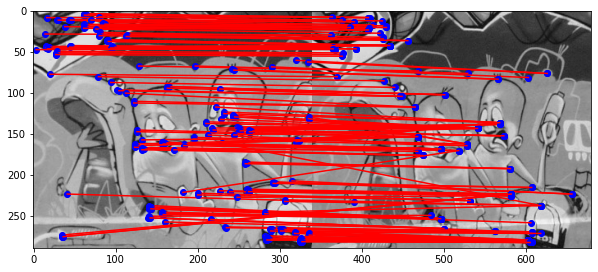

In [13]:
def display_matches(im1, im2, x1, y1, x2, y2, leftToRight):
	#leftToRight contains the indexes for points in the right image corresponding to the keypoints in the left image

	# NOTE: this will only work correctly for images with the same height
	# NOTE: matches should contain index pairs (i.e. first element is the index to pts1 and second for pts2)

	I = np.hstack((im1,im2))
	w = im1.shape[1]
	plt.clf()
	plt.imshow(I, cmap="gray")

	for i in range(len(x1)):
		plt.plot(x1[i], y1[i], 'bo')

		indexRightPoint = int(leftToRight[i])
		plt.plot(x2[indexRightPoint]+w, y2[indexRightPoint], 'bo')
		plt.plot([x1[i], x2[indexRightPoint]+w], [y1[i], y2[indexRightPoint]], 'r')

	plt.draw()
	#plt.waitforbuttonpress()

plt.rcParams["figure.figsize"] = [10,10]
display_matches(image, image2, x1, y1, x2, y2, indexMatches)

plt.rcParams["figure.figsize"] = backupPlotSize


## 2.c)

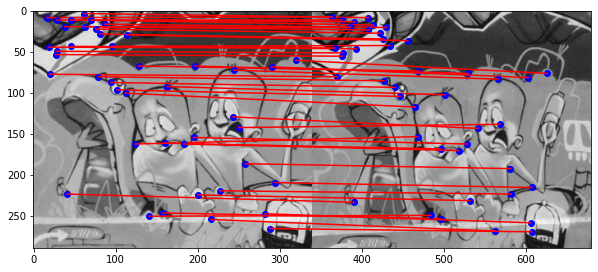

In [14]:
def display_matches2(im1, im2, x1, y1, x2, y2, leftToRight, rightToLeft):

	#leftToRight contains the indexes for points in the right image corresponding to the keypoints in the left image and vice versa

	I = np.hstack((im1,im2))
	w = im1.shape[1]
	plt.clf()
	plt.imshow(I, cmap="gray")

	for i in range(len(x1)):
		#check for symetry
		indexRightPoint = int(leftToRight[i])
		if rightToLeft[indexRightPoint] == i:

			plt.plot(x1[i], y1[i], 'bo')

			
			plt.plot(x2[indexRightPoint]+w, y2[indexRightPoint], 'bo')
			plt.plot([x1[i], x2[indexRightPoint]+w], [y1[i], y2[indexRightPoint]], 'r')

	plt.draw()
	#plt.waitforbuttonpress()

plt.rcParams["figure.figsize"] = [10,10]
display_matches2(image, image2, x1, y1, x2, y2, indexMatches, indexMatches2)

plt.rcParams["figure.figsize"] = backupPlotSize

## 2.d) Suggested improvements
Only keep those that have a low enough distance

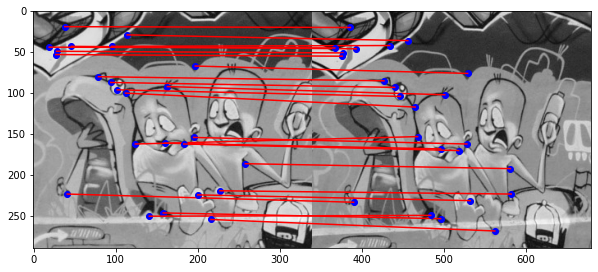

In [15]:
#check if the distance is below a threshold
def display_matches3(im1, im2, x1, y1, x2, y2, leftToRight, rightToLeft, distances, maxDistance):
	#leftToRight contains the indexes for points in the right image corresponding to the keypoints in the left image and vice versa

	I = np.hstack((im1,im2))
	w = im1.shape[1]
	plt.clf()
	plt.imshow(I, cmap="gray")

	for i in range(len(x1)):
         #check maxDistance
         if distances[i] < maxDistance:
            #check for symetry
            indexRightPoint = int(leftToRight[i])
            if rightToLeft[indexRightPoint] == i:
                plt.plot(x1[i], y1[i], 'bo')

                plt.plot(x2[indexRightPoint]+w, y2[indexRightPoint], 'bo')
                plt.plot([x1[i], x2[indexRightPoint]+w], [y1[i], y2[indexRightPoint]], 'r')

	plt.draw()


plt.rcParams["figure.figsize"] = [10,10]
display_matches3(image, image2, x1, y1, x2, y2, indexMatches, indexMatches2, distances=distances, maxDistance=0.11)

plt.rcParams["figure.figsize"] = backupPlotSize

In [16]:
video = cv2.VideoCapture('vid2.mp4')

def drawKeypointsOnVideo(vide0):
    #we need a resolution for the videoWriter
    frameWidth = int(video.get(3))
    frameHeight = int(video.get(4))
    
    size = (frameWidth, frameHeight)
    
    #videowriter will make a video from the frames, 30fps
    resultVideo = cv2.VideoWriter('outPutVideo.avi', cv2.VideoWriter_fourcc(*'MJPG'), 30, size)

    while(True):
        ret, frame = video.read()
    
        if ret == True: 
            #frame  =cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            imagebw  =cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

            maxFeatures = 100

            #can also ORB_create, sift looks better
            orb = cv2.SIFT_create(maxFeatures)
            keypoints, descriptors = orb.detectAndCompute(imagebw, None)

            cv2.drawKeypoints(frame, keypoints, frame,  color = (0, 255, 0),  flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

            #write the output frame to the video
            resultVideo.write(frame)
    
    
        # Break the loop
        else:
            break
    
    #release the objects
    video.release()
    resultVideo.release()
        
    #close all frames
    cv2.destroyAllWindows()




# 3.) Homography

## 3.a) SVD

In [17]:
A = np.zeros((8, 9))
#np.append(A, [1,1,1,1,1,1,1,1,1])
# 
# 
i=6
A[i,] = [1,1,1,1,1,1,1,1,1]
A[i+1,] = [1,1,1,1,1,1,1,1,1]
A
#np.append(A, first, axis=0)

#np.append(A, second, axis=0)

B = np.array(())
B

array([], dtype=float64)

In [18]:
#estimate homography given a set of matched feature points
def estimateHomography(ptsXr, ptsYr, ptsXt, ptsYt):

    #construct matrix A
    A = np.zeros((2*len(ptsXr), 9))
    
    print

    #sode indexe da lahko potem znotraj 
    for i in range(len(ptsXr)):
        #dve vrstici, za vsak par, po formuli
        first = [ptsXr[i], ptsYr[i], 1, 0, 0, 0, -ptsXt[i]*ptsXr[i], -ptsXt[i]*ptsYr[i], -ptsXt[i]]
        second = [0, 0, 0, ptsXr[i], ptsYr[i], 1, -ptsYt[i]*ptsXr[i], -ptsYt[i]*ptsYr[i], -ptsYt[i]]

        A[2*i,] = first
        A[2*i+1,] = second
    
    u, s, vh = np.linalg.svd(A)

    #A=USV'
    vh = np.transpose(vh)

    h=vh[:,-1]
    h=h/h[-1] #normaliziramo
    
    h=h.reshape(3,3)

    return h


V tej datoteki newyork je ena vrstica $x1_r \ y1_r \ x1_t \ y1_t$

Newyork:
21.005 96.416 64.866 52.372 
246.74 94.743 238.55 195.65 
25.099 185.06 10.479 122.62 
186.5 207.36 121.01 243.6

H:
0.7696 -0.6462 110.6267
0.6443 0.7498 -33.7646
0.0000 -0.0001 1.0000

[[ 7.69617242e-01 -6.46212051e-01  1.10626708e+02]
 [ 6.44347076e-01  7.49837927e-01 -3.37646117e+01]
 [ 3.92390513e-05 -6.90947229e-05  1.00000000e+00]]


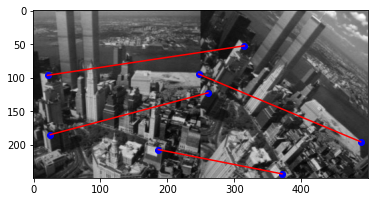

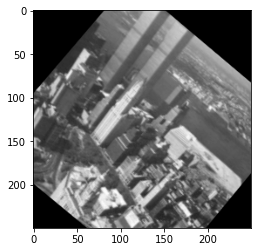

In [19]:
def display_matches22(im1, im2, x1, y1, x2, y2):
	I = np.hstack((im1,im2))
	w = im1.shape[1]
	plt.clf()
	plt.imshow(I, cmap="gray")

	for i in range(len(x1)):
		plt.plot(x1[i], y1[i], 'bo')

		plt.plot(x2[i]+w, y2[i], 'bo')
		plt.plot([x1[i], x2[i]+w], [y1[i], y2[i]], 'r')

	plt.draw()


newYork = cv2.imread("data/newyork/newyork1.jpg")
newYork = cv2.cvtColor(newYork, cv2.COLOR_BGR2GRAY)


newYork2 = cv2.imread("data/newyork/newyork2.jpg")
newYork2 = cv2.cvtColor(newYork2, cv2.COLOR_BGR2GRAY)

ptsXr = [21.005, 246.74, 25.099, 186.5]
ptsYr = [96.416, 94.743, 185.06, 207.36]
ptsXt = [64.866, 238.55, 10.479, 121.01]
ptsYt = [52.372 , 195.65, 122.62, 243.6]

homogMatrix = estimateHomography(ptsXr, ptsYr, ptsXt, ptsYt)

display_matches22(newYork, newYork2, ptsXr, ptsYr, ptsXt, ptsYt)

print(homogMatrix)

plt.show()
transformed =cv2.warpPerspective(newYork, homogMatrix, dsize=(newYork.shape[1], newYork.shape[0]))
plt.imshow(transformed, cmap="gray")


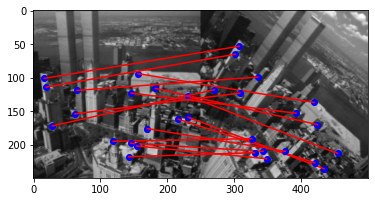

16 16 16 16


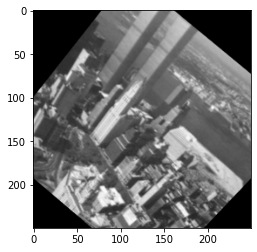

In [20]:
thresh = 13500 

hes1=hessianPoints(newYork, 3, thresh)
sup1 = nonMaximaSupression(hes1, thresh)
y1,x1 = np.nonzero(sup1)

hes2=hessianPoints(newYork2, 3, thresh)
sup2 = nonMaximaSupression(hes2, thresh)
y2,x2 = np.nonzero(sup2)

desc1 = simple_descriptors(newYork, x1, y1)
desc2 = simple_descriptors(newYork2, x2, y2)

indexMatches, distances = findCorrespondences(desc1, desc2, getDistance=True)
indexMatches2 = findCorrespondences(desc2, desc1)

#plota samo simetricne IN VRNE SAMO SIMETRICNE
def display_matches4(im1, im2, x1, y1, x2, y2, leftToRight, rightToLeft, maxDistance):
    I = np.hstack((im1,im2))
    w = im1.shape[1]
    plt.clf()
    plt.imshow(I, cmap="gray")

    #definiraj nove, s simetricnimi pari
    newX1, newY1, newX2, newY2 = np.array(()), np.array(()), np.array(()), np.array(())

    for i in range(len(x1)):
        #check for distance
        if distances[i] < maxDistance:
            #check for symetry
            indexRightPoint = int(leftToRight[i])
            if rightToLeft[indexRightPoint] == i:

                plt.plot(x1[i], y1[i], 'bo')
                plt.plot(x2[indexRightPoint]+w, y2[indexRightPoint], 'bo')
                plt.plot([x1[i], x2[indexRightPoint]+w], [y1[i], y2[indexRightPoint]], 'r')
                #add new pair
                newX1, newY1, newX2, newY2 = np.append(newX1, x1[i]), np.append(newY1, y1[i]), np.append(newX2, x2[indexRightPoint]), np.append(newY2, y2[indexRightPoint])

    plt.draw()

    return newX1, newY1, newX2, newY2
#plt.waitforbutt

x1, y1, x2, y2 = display_matches4(newYork, newYork2, x1, y1, x2, y2, indexMatches, indexMatches2, maxDistance=0.2)
plt.show()

print(len(x1), len(y1), len(x2), len(y2))

homogMatrix2 = estimateHomography(x1, y1, x2, y2)
transformed =cv2.warpPerspective(newYork, homogMatrix2, dsize=(newYork.shape[1], newYork.shape[0]))
plt.imshow(transformed, cmap="gray")



## 3.e) My warp perspective

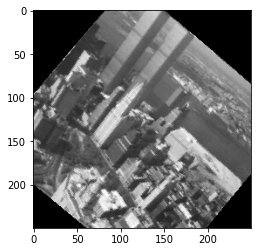

In [24]:

height, width = newYork.shape

indxTriplets = np.zeros((height*width,3))

myTrans=np.zeros((height,width))

invH = np.linalg.inv(homogMatrix) 

for x in range(width):
    for y in range(height):

        coord1 = np.array([x,y,1]).T
        #get transformed coordinate
        coordT = np.matmul(invH, coord1)
        coordT = coordT / coordT[-1]

        if(0 < coordT[1] < 250) and 0<coordT[0] < 250: 
            myTrans[y, x] = newYork[int(coordT[1])-1,int(coordT[0])-1]

#myTrans = myTrans.astype(np.uint8)
#myTrans = cv2.medianBlur(myTrans, 3,myTrans)
plt.imshow(myTrans, cmap="gray")


#PAZI KOORDINATE
#naredi seznam trojckov x,y,1
# indxTriplets[:,0]=np.repeat(np.arange(height), width)
# indxTriplets[:,1]=np.tile(np.arange(width), height)
# indxTriplets[:,2]=1
